## System Setup

In [ ]:
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}
# This is to overcome torch CUDA version issue. (It is not needed when using cpu only)
shell_call("wget https://storage.googleapis.com/torch-lantern-builds/packages/cu117/0.11.0/src/contrib/torch_0.11.0_R_x86_64-pc-linux-gnu.tar.gz")
install.packages("torch_0.11.0_R_x86_64-pc-linux-gnu.tar.gz", repos = NULL)
# For some reasons, the coro package (a torch dependency) is not installed from torch when using binaries
install.packages("coro")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
shell_call("grep -m1 'model name' /proc/cpuinfo | awk -F': ' '{printf \" CPU Model: %s \\n \",  $2}'")
shell_call("grep 'cpu cores' /proc/cpuinfo  | awk -F': ' '{a[cores]+=$2}END{printf \"CPU Cores: %s \\n \", a[cores] }'")
shell_call("grep MemTotal /proc/meminfo | awk '{printf \"RAM: %.1fGB \\n \", $2 / 1024 / 1024}'")
shell_call("R --version | head -n 1")

 CPU Model: Intel(R) Xeon(R) CPU @ 2.00GHz 
 CPU Cores: 32 
 RAM: 51.0GB 
 R version 4.3.1 (2023-06-16) -- "Beagle Scouts"

In [ ]:
shell_call("nvidia-smi")

Fri Oct 20 20:47:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
install.packages('BKTR')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sp’, ‘Rcpp’, ‘collections’, ‘RgoogleMaps’, ‘png’, ‘plyr’, ‘jpeg’, ‘bitops’, ‘R6P’, ‘ggmap’




## Simulation-based study (Section 5)

### Estimation of the parameters (5.1)

In [ ]:
library(BKTR)
library(ggplot2)

# Set seed and calculation params
TSR$set_params(seed = 1, fp_type='float64', fp_device='cpu')

# Use specific covariance matrix for simulation
matern_lenscale <- KernelParameter$new(value = 14)
se_lenscale <- KernelParameter$new(value = 5)
spatial_kernel <- KernelMatern$new(lengthscale = matern_lenscale)
temporal_kernel <- KernelSE$new(lengthscale = se_lenscale)

# Simulate data
simu_data <- simulate_spatiotemporal_data(
  nb_locations=100,
  nb_time_points=150,
  nb_spatial_dimensions=2,
  spatial_scale=10,
  time_scale=10,
  spatial_covariates_means=c(0, 2, 4),
  temporal_covariates_means=c(1, 3),
  spatial_kernel=spatial_kernel,
  temporal_kernel=temporal_kernel,
  noise_variance_scale=1)

# Create Regressor
bktr_regressor <- BKTRRegressor$new(
  data_df = simu_data$data_df,
  spatial_kernel = KernelMatern$new(),
  spatial_positions_df = simu_data$spatial_positions_df,
  temporal_kernel = KernelSE$new(),
  temporal_positions_df = simu_data$temporal_positions_df,
  has_geo_coords=FALSE)

# MCMC sampling
bktr_regressor$mcmc_sampling()

[1] "Iter 1     | Elapsed Time:     0.55s | MAE:  2.9356 | RMSE:  3.7555"
[1] "Iter 2     | Elapsed Time:     0.44s | MAE:  1.1503 | RMSE:  1.4522"
[1] "Iter 3     | Elapsed Time:     0.49s | MAE:  0.8629 | RMSE:  1.0821"
[1] "Iter 4     | Elapsed Time:     0.27s | MAE:  0.8293 | RMSE:  1.0376"
[1] "Iter 5     | Elapsed Time:     0.73s | MAE:  0.8243 | RMSE:  1.0293"
[1] "Iter 6     | Elapsed Time:     0.33s | MAE:  0.8192 | RMSE:  1.0257"
[1] "Iter 7     | Elapsed Time:     0.51s | MAE:  0.8199 | RMSE:  1.0266"
[1] "Iter 8     | Elapsed Time:     0.56s | MAE:  0.8171 | RMSE:  1.0246"
[1] "Iter 9     | Elapsed Time:     0.93s | MAE:  0.8171 | RMSE:  1.0238"
[1] "Iter 10    | Elapsed Time:     0.48s | MAE:  0.8151 | RMSE:  1.0211"
[1] "Iter 11    | Elapsed Time:     0.51s | MAE:  0.8182 | RMSE:  1.0245"
[1] "Iter 12    | Elapsed Time:     0.55s | MAE:  0.8160 | RMSE:  1.0222"
[1] "Iter 13    | Elapsed Time:     0.61s | MAE:  0.8127 | RMSE:  1.0210"
[1] "Iter 14    | Elapsed Time:     0.

In [ ]:
# Print Summary
summary(bktr_regressor)


                        BKTR Regressor Summary                        
Formula: y ~ .

Burn-in iterations: 500
Sampling iterations: 500
Rank decomposition: 10
Nb Spatial Locations: 100
Nb Temporal Points: 150
Nb Covariates: 6
In Sample Errors:
  RMSE: 1.001
  MAE: 0.797
Computation time: 604.75s.
-- Spatial Kernel --
Matern 5/2 Kernel
Parameter(s):
                       Mean   Median       SD  Low2.5p  Up97.5p
lengthscale          13.878   13.904    0.584   12.776   14.964

-- Temporal Kernel --
SE Kernel
Parameter(s):
                       Mean   Median       SD  Low2.5p  Up97.5p
lengthscale           4.603    4.616    0.246    4.038    5.054
Beta Estimates Summary (Aggregated Per Covariates)

                       Mean   Median       SD
Intercept             2.415    2.626    1.695
s_cov_0               2.452    2.638    1.411
s_cov_1              -4.224   -4.171    2.770
s_cov_2              -1.938   -1.952    0.467
t_cov_0              -2.372   -2.613    1.495
t_cov_1          

In [ ]:
# Print Beta Errors (Removing Time and Location columns)
beta_err <- unlist(abs(
    bktr_regressor$beta_estimates[, -c(1, 2)]
    - simu_data$beta_df[, -c(1, 2)]
))
print(sprintf('Beta RMSE: %.4f', sqrt(mean(beta_err^2))))
print(sprintf('Beta MAE: %.4f', mean(abs(beta_err))))

[1] "Beta RMSE: 0.1426"
[1] "Beta MAE: 0.0840"


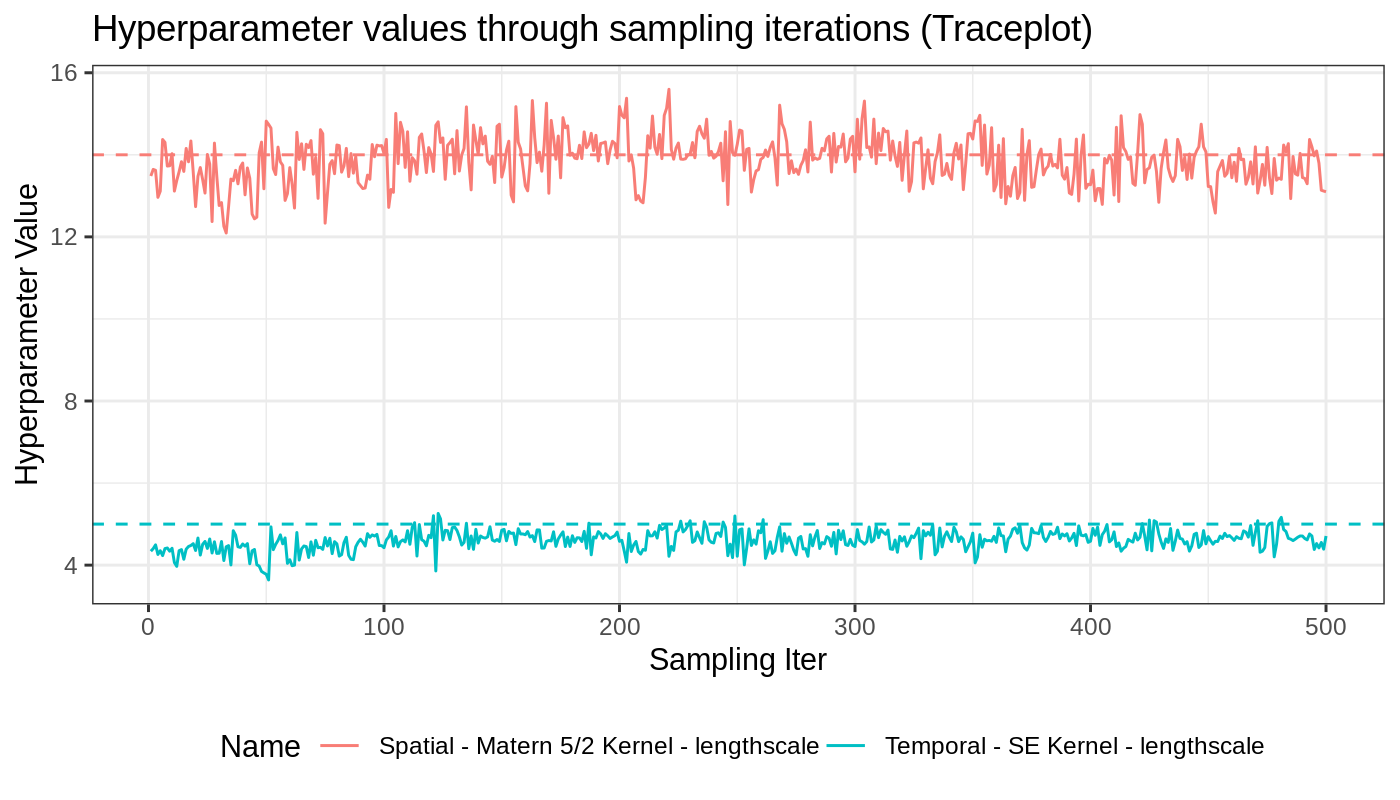

In [ ]:
# Create Traceplot
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 200)
fig <- plot_hyperparams_traceplot(bktr_regressor, c(
    'Spatial - Matern 5/2 Kernel - lengthscale',
    'Temporal - SE Kernel - lengthscale'
    ), show_figure = FALSE)

col_1 <- '#f87d76'; col_2 <- '#00bfc4';
fig +
    scale_colour_manual(name = 'Name', values = c(col_1, col_2)) +
    geom_hline(yintercept = matern_lenscale$value,
        linetype='dashed', col = col_1) +
    geom_hline(yintercept = se_lenscale$value,
        linetype = 'dashed', col = col_2)


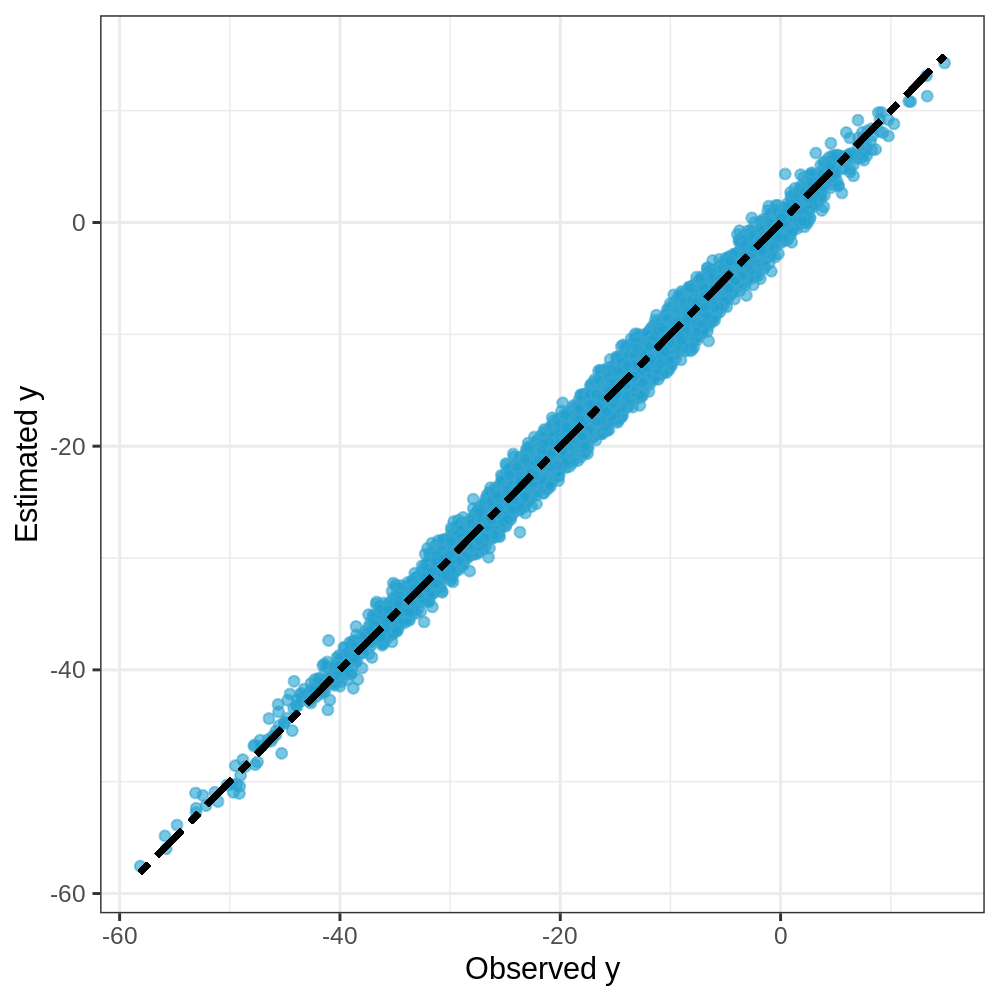

In [ ]:
# Plot y estimates
plot_y_estimates(bktr_regressor, fig_title=NULL)

### Imputation (5.2)

In [ ]:
library(BKTR)
library(data.table)
df_res_arr <- c()
res_colnames <- c('Lengthscale', 'Missing', 'Iter', 'B_MAE', 'B_RMSE', 'Y_MAE', 'Y_RMSE', 'Time')

RANK_DECOMP = 10
BURN_IN_ITER = 500
SAMPLING_ITER = 500

# Set seed and calculation params
TSR$set_params(seed = 1, fp_type = 'float32', fp_device = 'cuda')

for (len_scale in c(3, 6)) {
  for (miss_perc in c(0.1, 0.5, 0.9)) {
    for (i in 1:10) {
      spatial_kernel <- KernelMatern$new(
        smoothness_factor = 5,
        lengthscale = KernelParameter$new(value = len_scale)
      )
      temporal_kernel <- (
        KernelSE$new(lengthscale = KernelParameter$new(value = len_scale))
      )

      simu_data <- simulate_spatiotemporal_data(
        100, 150, 2, 10, 10,
        c(0, 2, 4), c(1, 3),
        spatial_kernel, temporal_kernel, 1
      )

      data_df <- simu_data$data_df
      index_choices_tsr <- TSR$tensor(1:nrow(data_df))
      nb_miss_index <- round(miss_perc * nrow(data_df))
      na_index <- as.numeric(TSR$rand_choice(index_choices_tsr, nb_miss_index)$cpu())
      data_df$y[na_index] <- NA

      bktr_regressor <- BKTRRegressor$new(
        data_df = data_df,
        rank_decomp = RANK_DECOMP,
        burn_in_iter = BURN_IN_ITER,
        sampling_iter = SAMPLING_ITER,
        spatial_kernel = KernelMatern$new(smoothness_factor = 5),
        spatial_positions_df = simu_data$spatial_positions_df,
        temporal_kernel = KernelSE$new(),
        temporal_positions_df = simu_data$temporal_positions_df,
        has_geo_coords = FALSE
      )

      # Hide output of sampling because its volume creates notebook errors
      .unused_out <- capture.output(bktr_regressor$mcmc_sampling())

      # Calc Beta Errors
      y_err <- bktr_regressor$imputed_y_estimates$y[na_index] - simu_data$data_df$y[na_index]
      beta_err <- unlist(abs(
        lapply(bktr_regressor$beta_estimates[, -c(1, 2)], as.numeric)
        - simu_data$beta_df[, -c(1, 2)]
      ))
      y_rmse <- sqrt(mean(y_err^2))
      y_mae <- mean(abs(y_err))
      beta_rmse <- sqrt(mean(beta_err^2))
      beta_mae <- mean(abs(beta_err))

      # Formatting Values
      df_res_arr <- c(
        df_res_arr,
        len_scale,
        miss_perc,
        sprintf('%04d', i),
        sprintf('%.4f', beta_mae),
        sprintf('%.4f', beta_rmse),
        sprintf('%.4f', y_mae),
        sprintf('%.4f', y_rmse),
        sprintf('%.3f', as.numeric(bktr_regressor$result_logger$total_elapsed_time,units="secs"))
      )
    }
  }
}
df <- as.data.table(matrix(df_res_arr, ncol = length(res_colnames), byrow = TRUE))
colnames(df) <- res_colnames
print(df)


    Lengthscale Missing Iter  B_MAE B_RMSE  Y_MAE Y_RMSE    Time
 1:           3     0.1 0001 0.6456 1.0041 0.8635 1.1012 241.712
 2:           3     0.1 0002 0.5799 0.8954 0.8546 1.0709 240.470
 3:           3     0.1 0003 0.4874 0.7505 0.8815 1.1130 229.883
 4:           3     0.1 0004 0.6279 0.9853 0.8475 1.0545 232.907
 5:           3     0.1 0005 0.6486 1.0885 0.9070 1.1385 234.558
 6:           3     0.1 0006 0.8176 1.4320 0.8908 1.1120 242.223
 7:           3     0.1 0007 0.5831 0.9181 0.8822 1.1079 248.592
 8:           3     0.1 0008 0.8822 1.3416 0.8786 1.1053 238.904
 9:           3     0.1 0009 0.7314 1.2229 0.8909 1.1225 237.124
10:           3     0.1 0010 0.6241 0.9776 0.8350 1.0579 245.519
11:           3     0.5 0001 0.6119 1.0885 0.9483 1.1904 228.975
12:           3     0.5 0002 0.8920 1.4378 0.9092 1.1502 233.761
13:           3     0.5 0003 0.7023 1.0910 0.9179 1.1531 229.762
14:           3     0.5 0004 0.5455 0.8311 0.8671 1.1008 227.512
15:           3     0.5 0

In [ ]:
# Format data.table aggregated results
mean_fmt <- function(x) sprintf('%.4f', mean(x))
sd_fmt <- function(x) sprintf('%.4f', sd(x))

df <- df[, lapply(.SD, as.numeric), by=list(Lengthscale, Missing)]
df <- df[, .(
  B_MAE_avg = mean_fmt(B_MAE),
  B_MAE_sd = sd_fmt(B_MAE),
  B_RMSE_avg = mean_fmt(B_RMSE),
  B_RMSE_sd = sd_fmt(B_RMSE),
  Y_MAE_avg = mean_fmt(Y_MAE),
  Y_MAE_sd = sd_fmt(Y_MAE),
  Y_RMSE_avg = mean_fmt(Y_RMSE),
  Y_RMSE_sd = sd_fmt(Y_RMSE),
  Time_avg = mean_fmt(Time),
  Time_sd = sd_fmt(Time)
), by=list(Lengthscale, Missing)]
setkey(df, Lengthscale, Missing)
print(df)

   Lengthscale Missing B_MAE_avg B_MAE_sd B_RMSE_avg B_RMSE_sd Y_MAE_avg
1:           3     0.1    0.6628   0.1174     1.0616    0.2117    0.8732
2:           3     0.5    0.6393   0.1575     1.0285    0.2906    0.9071
3:           3     0.9    0.6291   0.0794     0.9148    0.1169    1.1044
4:           6     0.1    0.2347   0.0522     0.3992    0.1053    0.8108
5:           6     0.5    0.1967   0.0266     0.3146    0.0467    0.8218
6:           6     0.9    0.2698   0.0440     0.4300    0.0912    0.8909
   Y_MAE_sd Y_RMSE_avg Y_RMSE_sd Time_avg Time_sd
1:   0.0224     1.0984    0.0280 239.1892  5.7499
2:   0.0304     1.1439    0.0378 232.7056  3.0905
3:   0.0566     1.4208    0.0833 217.4581  2.5339
4:   0.0160     1.0186    0.0239 218.0962  5.2847
5:   0.0085     1.0299    0.0098 213.3479  6.0397
6:   0.0155     1.1200    0.0191 197.4833  4.3859


### Interpolation (5.3)

#### Interpolation Size + Lengthscale Effect

In [ ]:
library(BKTR)
library(data.table)

nb_aside_locs <- 4
nb_aside_times <- 6

# Set seed and calculation params
TSR$set_params(seed = 2, fp_type = 'float32', fp_device = 'cuda')
res_colnames <- c('Dataset_Type', 'Lengthscale', 'Iter', 'B_MAE', 'B_RMSE', 'Y_MAE', 'Y_RMSE', 'Time')
nb_res_cols <- length(res_colnames)
res_vals <- c()
for (ds_type in c('Smaller', 'Larger')) {
  for (len_scale in c(3, 6)) {
    for (i in 1:10) {
      matern_lengthscale <- KernelParameter$new(value = len_scale)
      se_lengthscale <- KernelParameter$new(value = len_scale)
      spatial_kernel <- KernelMatern$new(lengthscale = matern_lengthscale, smoothness_factor = 5)
      temporal_kernel <- KernelSE$new(lengthscale = se_lengthscale)

      is_small_ds <- ds_type == 'Smaller'
      nb_locs <- ifelse(is_small_ds, 20, 100)
      nb_times <- ifelse(is_small_ds, 30, 150)
      spa_cov_means <- if(is_small_ds) c(0, 2) else c(0, 2, 4)
      tem_cov_means <- if(is_small_ds) c(1) else c(1, 3)

      simu_data <- simulate_spatiotemporal_data(
        nb_locations=nb_locs,
        nb_time_points=nb_times,
        nb_spatial_dimensions=2,
        spatial_scale=10,
        time_scale=10,
        spatial_covariates_means=spa_cov_means,
        temporal_covariates_means=tem_cov_means,
        spatial_kernel=spatial_kernel,
        temporal_kernel=temporal_kernel,
        noise_variance_scale=1
      )

      # Set some values aside for M_new locs and N_new times
      obs_nb_locs <- nb_locs - nb_aside_locs
      obs_nb_times <- nb_times - nb_aside_times

      data_df <- simu_data$data_df
      spatial_pos_df <- simu_data$spatial_positions_df
      temporal_pos_df <- simu_data$temporal_positions_df

      all_locs <- spatial_pos_df$location
      all_times <- temporal_pos_df$time

      locs_indx_sample <- TSR$rand_choice(TSR$tensor(1:length(all_locs)), obs_nb_locs)
      obs_locs <- all_locs[as.numeric(locs_indx_sample$cpu())]
      new_locs <- setdiff(all_locs, obs_locs)

      times_indx_sample <- TSR$rand_choice(TSR$tensor(1:length(all_times)), obs_nb_times)
      obs_times <- all_times[as.numeric(times_indx_sample$cpu())]
      new_times <- setdiff(all_times, obs_times)

      obs_data_df <- data_df[data_df[, .I[location %in% obs_locs & time %in% obs_times]], ]
      obs_spatial_pos_df <- spatial_pos_df[spatial_pos_df[, .I[location %in% obs_locs]], ]
      obs_temporal_pos_df <- temporal_pos_df[temporal_pos_df[, .I[time %in% obs_times]], ]

      new_data_df <- data_df[data_df[, .I[location %in% new_locs | time %in% new_times]], ]
      new_spatial_positions_df <- spatial_pos_df[spatial_pos_df[, .I[location %in% new_locs]], ]
      new_temporal_positions_df <- temporal_pos_df[temporal_pos_df[, .I[time %in% new_times]], ]

      # Run mcmc sampling
      bktr_regressor <- BKTRRegressor$new(
        data_df=obs_data_df,
        rank_decomp = 10,
        burn_in_iter = 500,
        sampling_iter = 500,
        spatial_kernel=KernelMatern$new(smoothness_factor = 5),
        spatial_positions_df=obs_spatial_pos_df,
        temporal_kernel=KernelSE$new(),
        temporal_positions_df=obs_temporal_pos_df,
        has_geo_coords=FALSE
      )
      # Hide output of sampling because its volume creates notebook errors
      .unused_out <- capture.output(bktr_regressor$mcmc_sampling())

      # Run interpolation
      preds <- bktr_regressor$predict(
        new_data_df,
        new_spatial_positions_df,
        new_temporal_positions_df
      )

      # Align both datasets
      sim_data_df <- simu_data$data_df
      pred_y_df <- preds$new_y_df
      beta_data_df <- simu_data$beta_df
      beta_pred_df <- preds$new_beta_df
      setkey(beta_pred_df, location, time)
      sim_y_df <- sim_data_df[sim_data_df[, .I[location %in% new_locs | time %in% new_times]], c('location', 'time', 'y')]
      setorderv(pred_y_df, c('location', 'time'))
      setorderv(sim_y_df, c('location', 'time'))

      # Calc Errors
      preds_y_err <- (
        sim_data_df[sim_data_df[, .I[location %in% new_locs | time %in% new_times]], 'y']
        - pred_y_df[pred_y_df[, .I[location %in% new_locs | time %in% new_times]], 'y_est']
      )
      preds_y_err <- unlist(preds_y_err)
      preds_beta_err <- (
        beta_data_df[beta_data_df[, .I[location %in% new_locs | time %in% new_times]], -c('location', 'time')]
        - beta_pred_df[beta_pred_df[, .I[location %in% new_locs | time %in% new_times]], -c('location', 'time')]
      )
      preds_beta_err <- unlist(preds_beta_err)

      y_rmse <- sqrt(mean(preds_y_err^2))
      y_mae <- mean(abs(preds_y_err))
      beta_rmse <- sqrt(mean(preds_beta_err^2))
      beta_mae <- mean(abs(preds_beta_err))

      # Formatting Values
      res_vals <- c(
        res_vals,
        ds_type,
        len_scale,
        sprintf('%04d', i),
        sprintf('%.4f', beta_mae),
        sprintf('%.4f', beta_rmse),
        sprintf('%.4f', y_mae),
        sprintf('%.4f', y_rmse),
        sprintf('%.3f', as.numeric(bktr_regressor$result_logger$total_elapsed_time,units="secs"))
      )
    }
  }
}
df <- as.data.table(matrix(res_vals, ncol = nb_res_cols, byrow = TRUE))
colnames(df) <- res_colnames
print(df)

    Dataset_Type Lengthscale Iter  B_MAE B_RMSE  Y_MAE Y_RMSE    Time
 1:      Smaller           3 0001 0.6670 0.8332 1.1974 1.5111 134.007
 2:      Smaller           3 0002 0.9529 1.2503 1.5377 1.9840 147.488
 3:      Smaller           3 0003 0.8628 1.1268 2.1750 2.9890 142.623
 4:      Smaller           3 0004 1.4385 2.1017 3.0095 4.9898 146.796
 5:      Smaller           3 0005 0.5635 0.7513 1.1184 1.4086 147.957
 6:      Smaller           3 0006 0.8864 1.1969 1.8109 2.5438 143.304
 7:      Smaller           3 0007 0.5355 0.7361 1.2041 1.5673 140.233
 8:      Smaller           3 0008 0.8323 1.1144 1.6714 2.1864 142.089
 9:      Smaller           3 0009 0.6024 0.8148 1.4576 1.8679 145.856
10:      Smaller           3 0010 0.7943 1.2347 1.3611 1.7703 139.395
11:      Smaller           6 0001 0.8027 1.0049 1.3901 1.8623 135.577
12:      Smaller           6 0002 0.7907 1.0403 1.6107 2.2939 139.455
13:      Smaller           6 0003 0.5569 0.7806 1.0854 1.3683 129.553
14:      Smaller    

In [ ]:
# Format data.table aggregated results
mean_fmt <- function(x) sprintf('%.4f', mean(x))
sd_fmt <- function(x) sprintf('%.4f', sd(x))

df <- df[, lapply(.SD, as.numeric), by=list(Dataset_Type, Lengthscale)]
df <- df[, .(
  B_MAE_avg = mean_fmt(B_MAE),
  B_MAE_sd = sd_fmt(B_MAE),
  B_RMSE_avg = mean_fmt(B_RMSE),
  B_RMSE_sd = sd_fmt(B_RMSE),
  Y_MAE_avg = mean_fmt(Y_MAE),
  Y_MAE_sd = sd_fmt(Y_MAE),
  Y_RMSE_avg = mean_fmt(Y_RMSE),
  Y_RMSE_sd = sd_fmt(Y_RMSE),
  Time_avg = mean_fmt(Time),
  Time_sd = sd_fmt(Time)
), by=list(Dataset_Type, Lengthscale)]
setkey(df, Dataset_Type, Lengthscale)
print(df)

   Dataset_Type Lengthscale B_MAE_avg B_MAE_sd B_RMSE_avg B_RMSE_sd Y_MAE_avg
1:       Larger           3    1.1162   0.6259     1.7977    1.0208    2.2314
2:       Larger           6    0.2563   0.0689     0.4145    0.1495    1.0484
3:      Smaller           3    0.8136   0.2634     1.1160    0.4026    1.6543
4:      Smaller           6    0.5564   0.1766     0.7596    0.2592    1.1505
   Y_MAE_sd Y_RMSE_avg Y_RMSE_sd Time_avg Time_sd
1:   1.1513     3.4401    2.2293 230.6390  5.4904
2:   0.1795     1.4068    0.3690 218.9732  5.5767
3:   0.5744     2.2818    1.0698 142.9748  4.3444
4:   0.2189     1.5061    0.3489 133.2385  4.6234


#### Interpolation Predictions per portions

In [ ]:
# Functions for formatting purposes
get_df_errors <- function(l_df, l_col, r_df, r_col, loc_subset, time_subset, use_and=TRUE) {
  if(use_and){
    l_indx <- which(l_df[, location] %in% loc_subset & l_df[, time] %in% time_subset)
    r_indx <- which(r_df[, location] %in% loc_subset & r_df[, time] %in% time_subset)
  } else {
    l_indx <- which(l_df[, location] %in% loc_subset | l_df[, time] %in% time_subset)
    r_indx <- which(r_df[, location] %in% loc_subset | r_df[, time] %in% time_subset)
  }
  err <- unlist(l_df[l_indx, ..l_col] - r_df[r_indx, ..r_col])
  return(c(mean(abs(err)), sqrt(mean(err ** 2))))
}

get_all_errors <- function(segment_name, i, sim_data_df, pred_y_df, beta_data_df,
  beta_pred_df, loc_subset, time_subset, use_and=TRUE) {
  y_err <- get_df_errors(sim_data_df, 'y', pred_y_df, 'y_est', loc_subset, time_subset, use_and=use_and)
  beta_colnames <- setdiff(colnames(beta_pred_df), c('location', 'time'))
  beta_err <- get_df_errors(beta_data_df, beta_colnames, beta_pred_df,
      beta_colnames, loc_subset, time_subset, use_and=use_and)

  return(c(
    segment_name,
    sprintf('%04d', i),
    sprintf('%.4f', beta_err[1]),
    sprintf('%.4f', beta_err[2]),
    sprintf('%.4f', y_err[1]),
    sprintf('%.4f', y_err[2])
  ))
}


In [ ]:
library(BKTR)
library(data.table)

# Simu Params
nb_aside_locs <- 10
nb_aside_times <- 20
nb_locs <- 100
nb_times <- 150
len_scale <- 6
spa_cov_means <- c(0, 2, 4)
tem_cov_means <- c(1, 3)


# Set seed and calculation params
TSR$set_params(seed = 1, fp_type = 'float32', fp_device = 'cuda')
res_colnames <- c('Interpol_Segment', 'Iter', 'B_MAE', 'B_RMSE', 'Y_MAE', 'Y_RMSE')
nb_res_cols <- length(res_colnames)
res_vals <- c()
for (i in 1:10) {
  matern_lengthscale <- KernelParameter$new(value = len_scale)
  se_lengthscale <- KernelParameter$new(value = len_scale)
  spatial_kernel <- KernelMatern$new(lengthscale = matern_lengthscale)
  temporal_kernel <- KernelSE$new(lengthscale = se_lengthscale)

  simu_data <- simulate_spatiotemporal_data(
    nb_locations=nb_locs,
    nb_time_points=nb_times,
    nb_spatial_dimensions=2,
    spatial_scale=10,
    time_scale=10,
    spatial_covariates_means=spa_cov_means,
    temporal_covariates_means=tem_cov_means,
    spatial_kernel=spatial_kernel,
    temporal_kernel=temporal_kernel,
    noise_variance_scale=1
  )

  # Set some values aside for M_new locs and N_new times
  obs_nb_locs <- nb_locs - nb_aside_locs
  obs_nb_times <- nb_times - nb_aside_times

  data_df <- simu_data$data_df
  spatial_pos_df <- simu_data$spatial_positions_df
  temporal_pos_df <- simu_data$temporal_positions_df

  all_locs <- spatial_pos_df$location
  all_times <- temporal_pos_df$time
  obs_locs <- sample(all_locs, obs_nb_locs)
  new_locs <- setdiff(all_locs, obs_locs)
  obs_times <- sample(all_times, obs_nb_times)
  new_times <- setdiff(all_times, obs_times)

  obs_data_df <- data_df[data_df[, .I[location %in% obs_locs & time %in% obs_times]], ]
  obs_spatial_pos_df <- spatial_pos_df[spatial_pos_df[, .I[location %in% obs_locs]], ]
  obs_temporal_pos_df <- temporal_pos_df[temporal_pos_df[, .I[time %in% obs_times]], ]

  new_data_df <- data_df[data_df[, .I[location %in% new_locs | time %in% new_times]], ]
  new_spatial_positions_df <- spatial_pos_df[spatial_pos_df[, .I[location %in% new_locs]], ]
  new_temporal_positions_df <- temporal_pos_df[temporal_pos_df[, .I[time %in% new_times]], ]

  # Run mcmc sampling
  bktr_regressor <- BKTRRegressor$new(
    data_df=obs_data_df,
    spatial_kernel=KernelMatern$new(),
    spatial_positions_df=obs_spatial_pos_df,
    temporal_kernel=KernelSE$new(),
    temporal_positions_df=obs_temporal_pos_df,
    burn_in_iter = 1000,
    sampling_iter = 500,
    has_geo_coords=FALSE
  )
  # Hide output of sampling because its volume creates notebook errors
  .unused_out <- capture.output(bktr_regressor$mcmc_sampling())

  # Run interpolation
  preds <- bktr_regressor$predict(
    new_data_df,
    new_spatial_positions_df,
    new_temporal_positions_df
  )

  # Align both datasets
  sim_data_df <- simu_data$data_df
  pred_y_df <- preds$new_y_df
  beta_data_df <- simu_data$beta_df
  beta_pred_df <- preds$new_beta_df
  setkey(beta_pred_df, location, time)
  sim_y_df <- sim_data_df[sim_data_df[, .I[location %in% new_locs | time %in% new_times]], c('location', 'time', 'y')]
  setorderv(pred_y_df, c('location', 'time'))
  setorderv(sim_y_df, c('location', 'time'))

  # Formatting Values
  res_vals <- c(
    res_vals,
    get_all_errors('1_new_spa',  i, sim_data_df, pred_y_df, beta_data_df, beta_pred_df, new_locs, obs_times),
    get_all_errors('2_new_temp', i, sim_data_df, pred_y_df, beta_data_df, beta_pred_df, obs_locs, new_times),
    get_all_errors('3_new_both', i, sim_data_df, pred_y_df, beta_data_df, beta_pred_df, new_locs, new_times),
    get_all_errors('new_total', i, sim_data_df, pred_y_df, beta_data_df, beta_pred_df, new_locs, new_times, use_and = F)
  )
}
df <- as.data.table(matrix(res_vals, ncol = nb_res_cols, byrow = TRUE))
colnames(df) <- res_colnames
print(df)

    Interpol_Segment Iter  B_MAE B_RMSE  Y_MAE Y_RMSE
 1:        1_new_spa 0001 0.2003 0.3218 0.9374 1.1672
 2:       2_new_temp 0001 0.2003 0.3180 0.8012 1.0123
 3:       3_new_both 0001 0.1951 0.3201 0.8845 1.1363
 4:        new_total 0001 0.2000 0.3196 0.8599 1.0834
 5:        1_new_spa 0002 0.3792 0.5595 1.2352 1.5869
 6:       2_new_temp 0002 0.2723 0.4367 0.8111 1.0163
 7:       3_new_both 0002 0.3636 0.5430 1.0705 1.3623
 8:        new_total 0002 0.3200 0.4952 0.9939 1.2915
 9:        1_new_spa 0003 0.1919 0.2795 1.0111 1.2692
10:       2_new_temp 0003 0.1832 0.2999 0.7993 1.0016
11:       3_new_both 0003 0.1875 0.2650 1.0387 1.3183
12:        new_total 0003 0.1869 0.2900 0.8972 1.1345
13:        1_new_spa 0004 0.1967 0.2881 0.9731 1.2492
14:       2_new_temp 0004 0.2002 0.3150 0.8161 1.0230
15:       3_new_both 0004 0.1914 0.2778 0.9369 1.1782
16:        new_total 0004 0.1983 0.3025 0.8853 1.1268
17:        1_new_spa 0005 0.1873 0.2955 0.8300 1.0356
18:       2_new_temp 0005 0.

In [ ]:
# Format data.table
mean_fmt <- function(x) sprintf('%.4f', mean(x))
sd_fmt <- function(x) sprintf('%.4f', sd(x))

df <- df[, lapply(.SD, as.numeric), by=list(Interpol_Segment)]
df <- df[, .(
    B_MAE_avg = mean_fmt(B_MAE),
    B_MAE_sd = sd_fmt(B_MAE),
    B_RMSE_avg = mean_fmt(B_RMSE),
    B_RMSE_sd = sd_fmt(B_RMSE),
    Y_MAE_avg = mean_fmt(Y_MAE),
    Y_MAE_sd = sd_fmt(Y_MAE),
    Y_RMSE_avg = mean_fmt(Y_RMSE),
    Y_RMSE_sd = sd_fmt(Y_RMSE)
), by=list(Interpol_Segment)]
setkey(df, Interpol_Segment)
print(df)

   Interpol_Segment B_MAE_avg B_MAE_sd B_RMSE_avg B_RMSE_sd Y_MAE_avg Y_MAE_sd
1:        1_new_spa    0.2442   0.0630     0.3781    0.1030    1.0518   0.1440
2:       2_new_temp    0.2182   0.0318     0.3537    0.0554    0.8055   0.0116
3:       3_new_both    0.2419   0.0588     0.3742    0.0992    1.0209   0.1377
4:        new_total    0.2299   0.0433     0.3662    0.0726    0.9156   0.0663
   Y_RMSE_avg Y_RMSE_sd
1:     1.3440    0.2154
2:     1.0125    0.0130
3:     1.3119    0.2036
4:     1.1758    0.1127
